## 04 Data Simulation

written by **Jinwoo Lee**            
jil527@ucsd.edu | jinwoo-lee.com

Nov 19th, 2025  
as a PSYC201A's **Reproduction Project**

**Note:** This script aims to simulate participants' trait anxiety raw data ($X$) and distance matrix of vPFC-amygdala pathway morphology ($D_y$) based on the distribution and descriptive statistics of $X$ and correlation coefficient between the mean matrix of $X$, $D_x$ and $D_y$. Thus, the data simulation will proceed in the following order:   

1. simulate $X$ based on its distribution and descriptive statistics (e.g., mean and standard deviation).   
2. using the reported correlation coefficient between $D_x$ and $D_y$, simulate $D_y$ from the generated $X$. 

The main goal of the simulation is to understand the latent data generation process of the observed data and check whether the key statistics - spearman's rho and p-value from the Mantel Permutation tests can be reproduced with the simulated dataset.     

For this purpose, we will utilize parts of the **‘DIM’** package, which was custom-developed for the First Year Project. Since **DIM** is part of an ongoing research project in our lab, the corresponding GitHub repository is not publicly available.

---
### Step 1. Loading the Packages

I will load some fundamental packages for data simulation (e.g., `numpy` and `scipy`) and self-developed package, `DIM` for Anna Karenina model testing. Please see `03_reproduction-with-ours.ipynb` for detailed description of `DIM`.

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt

sys.path.insert(0, '../DIM/src')
from lib.dim.level1 import Level1  # importing our DIM package
from scipy.stats import rankdata

---
### Step 2. Simulate raw data of trait anxiety ($X$)

First, I will simulate raw data of trait anxiety ($X$) based on its distribution and descriptive statstics.

#### 2-A. Preparing the trait anxiety score data
Before the simulation, I will prepare 119 young adults' trait anxiety score data as done in `03_reproduction-with-ours.ipynb`.

In [2]:
### Load the Data
meta = pd.read_csv('../data-from-authors/Meta.csv')
STAI = pd.read_csv('../data-from-authors/STAI_G_X2.csv')

### Filtering 'Young' Group Samples
## (1) filtering by age
youth = meta[meta['Age'].isin(['20-25', '25-30', '30-35'])]

## (2) filtering by availability of MRI data
exclude_subjects = ['sub-032339', 'sub-032341', 'sub-032459', 'sub-032370', 
                    'sub-032466', 'sub-032438', 'sub-032509']
youth = youth[~youth['Unnamed: 0'].isin(exclude_subjects)]

## (3) filtering by SKID Diagnoses
youth['SKID_Diagnoses'] = pd.Categorical(youth['SKID_Diagnoses'])
youth['SKID_Diagnoses_numeric'] = youth['SKID_Diagnoses'].cat.codes + 1 
Hyouth = youth[(youth['SKID_Diagnoses_numeric'] == 0) | (youth['SKID_Diagnoses_numeric'] == 10)]

### Leaving Only Relevant Info
columns_to_drop = list(range(3, 14)) + list(range(15, 21))  
Hyouth = Hyouth.drop(Hyouth.columns[columns_to_drop], axis=1)

### Merging STAI data with Hyouth
Hyouth = pd.merge(Hyouth, STAI, on = 'Unnamed: 0')

# IMPORTANT: Matching the order of subjects with brain morphology data
Hyouth = Hyouth.sort_values('Unnamed: 0').reset_index(drop = True)

### Constructing the Young Samples' STAI Scores Array
stai_values = Hyouth[['STAI_Trait_Anxiety']].to_numpy()

#### 2-B. Investigating the data distribution and statistics
To simulate the raw data of trait anxiety, I need to figure out which distribution and parameters represent the real data best.

Best distribution: gamma
Parameters: (np.float64(17.119327755667634), np.float64(3.1009210637064513), np.float64(1.988999909794479))
Error: 0.2258596516761717


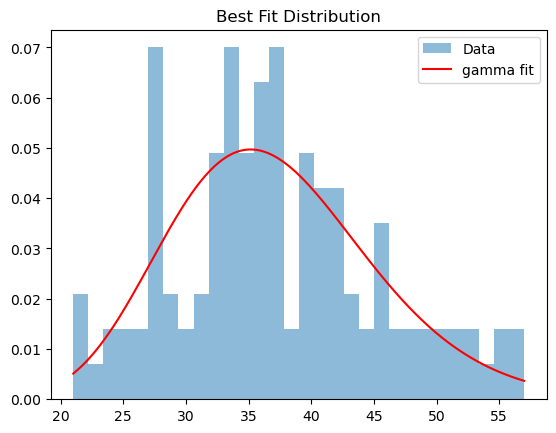

In [3]:
### Define a function that explores the best distribution function for the stai_values
def best_fit_distribution(data, distributions = None, bins = 100):
    """Return best fit distribution name and fitted parameters"""
    
    # the list of candidate distributions
    if distributions is None:
        distributions = [
            st.norm, st.expon, st.gamma, st.beta, st.uniform, st.t
        ]

    # histogram
    y, x = np.histogram(data, bins=bins, density=True)
    x_mid = (x + np.roll(x, -1))[:-1] / 2

    best_distribution = None
    best_params = None
    lowest_sse = np.inf

    for distribution in distributions:
        try:
            # fitting the distribution
            params = distribution.fit(data)

            # fitted posterior density function 
            pdf = distribution.pdf(x_mid, *params)

            # squared sum error (metric)
            sse = np.sum((y - pdf)**2)

            # updating the best distribution
            if sse < lowest_sse:
                best_distribution = distribution
                best_params = params
                lowest_sse = sse

        except Exception:
            pass

    return best_distribution, best_params, lowest_sse


### Define a function that visualizes the relationship between the best distribution and real data
def plot_best_fit(data, distribution, params):
    x = np.linspace(min(data), max(data), 200)
    pdf = distribution.pdf(x, *params)

    plt.hist(data, bins=30, density=True, alpha=0.5, label="Data")
    plt.plot(x, pdf, 'r-', label=f"{distribution.name} fit")
    plt.legend()
    plt.title("Best Fit Distribution")
    plt.show()

best_dist, best_params, error = best_fit_distribution(stai_values)

print("Best distribution:", best_dist.name)
print("Parameters:", best_params)
print("Error:", error)

plot_best_fit(stai_values, best_dist, best_params)


#### 2-C. Simulating the trait anxiety data with Gamma distribution

I found above that the $\text{gamma}(k = 17.12, \text{loc} = 3.10, \theta = 1.99)$ best represents the trait anxiety data. Based on this finding, I will simulate the trait anxiety data, `stai_values_sim`.

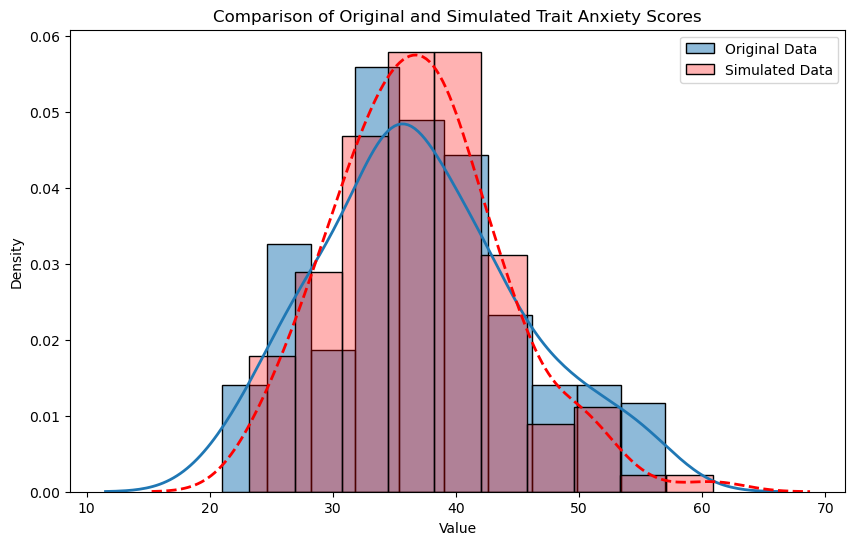

In [4]:
# data simulation
n_samples = len(stai_values)
stai_values_sim = st.gamma.rvs(a = best_params[0], loc = best_params[1], scale = best_params[2], size = n_samples, random_state = 42)

# visualize the distributions of simulated and real trait anxiety scores
plt.figure(figsize=(10,6))

sns.histplot(stai_values, color='blue', label='Original Data', stat='density', bins=10, kde=False, alpha=0.5)
sns.kdeplot(stai_values, color='blue', lw=2)

sns.histplot(stai_values_sim, color='red', label='Simulated Data', stat='density', bins=10, kde=False, alpha=0.3)
sns.kdeplot(stai_values_sim, color='red', lw=2, linestyle='--')

plt.legend()
plt.title('Comparison of Original and Simulated Trait Anxiety Scores')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

---
### Step 3. Simulate the distance matrix of vPFC-amygdala morphology ($D_y$) with $X$

I simulated the 119 participants' trait anxiety score, $X$ above. Based on this data, I will further simulate the 119*119 intersubject distance matrix of vPFC-amygdala morphology, $D_y$, which correlates to $X$ with spearman's rho = .148. To this end, I will take two steps:

1. Transform $X$ to $D_x$, a mean matrix of trait anxiety score following the logic of Anna Karenina model.     
2. Using $D_x$ and $\rho$ = .148, simulate $D_y$.     

For the second step, I need to convert $D_x$ to an 1D vector, $D_x^{*}$. In this case, $D_y^{*}$ will be $$D_y^{*} = \rho \cdot \text{rank}(D_x^{*}) + (1- \rho) \cdot \text{rank}(z)$$ where $z$ is a random noise vector. By reshaping $D_y^{*}$ to 119*119 matrix, I can generate a distance matrix $D_y$.

In [6]:
### 1. transform X to D_x using broadcasting
stai_matrix_sim = (stai_values_sim.reshape(-1,1) + stai_values_sim.reshape(1,-1)) / 2 # calculating mean STAI score of all possible pairs
print(stai_matrix_sim.shape)

### 2. simulate D_y
np.random.seed(42)
target_rho = .148

z = np.random.randn(n_samples * n_samples) # random noise vector
D_x_star = stai_matrix_sim.flatten()       # transform (119, 119) matrix into (119*119, ) vector
D_y_star = rankdata(D_x_star) * target_rho + rankdata(z) * (1 - target_rho) # simulate D_y_star

HAnnaKBrain_sim = D_y_star.reshape(n_samples, n_samples) # transform (119*119, ) vector into (119, 119) matrix
print(HAnnaKBrain_sim.shape)

(119, 119)
(119, 119)


---
### Step 4. Reproducing the correlation between simulated data

I completed to simulate raw trait anxiety score and distance matrix of vPFC-amygdala morphology ($X$ and $D_y$, respectively). Let's investigate whether the reported spearman's rho can be reproduced in these simulated datasets! 

In [7]:
### Defining the Model 
AnnaK_model = Level1(
    model = "AnnaK",
    distance = "Mean",
    weighting = "None",
    dependency = "spearman_r",
    normalize = False # not normalizing the stai_values as in the original study
)

### Fitting the Model
AnnaK_model.fit(stai_values_sim.reshape(-1, 1), HAnnaKBrain_sim) # need to shape stai_values_sim (119, 1) instead of (119,)

### Conducting Permutation Test for Calculating P-value
mantel_result = AnnaK_model.permutation_test_discovery(
    n_perms = 10000,
    verbose = True,
    return_null_dist = True,
    seed = 42
)

mantel_result

Validation successful!


Permutation test (refitting): 100%|██████████| 10000/10000 [00:15<00:00, 660.22perm/s]


{'observed_stat': 0.15961900353431702,
 'p_value': np.float64(0.0),
 'n_perms': 10000,
 'null_mean': np.float64(0.00011979208463196187),
 'null_std': np.float64(0.01744398393887743),
 'computation_time': 15.162882089614868,
 'null_distribution': array([ 0.01714665, -0.02017989, -0.00593718, ...,  0.0040301 ,
         0.01647893, -0.00172822], shape=(10000,))}